# Documentation
> Nous allons utiliser le language Markdown pour rédiger notre contenu.
> Vous pourriez consulter la documentation de ce language en exécutant la ligne ci-dessous :


In [ ]:
from IPython.display import IFrame
documentation = IFrame(src='https://guides.github.com/features/mastering-markdown/', width=1000, height=500)
display(documentation)

## Utiliser la librairie ```Geopy``` pour récupérer les coordonnées
> Découvrez sa documentation en exécutant la ligne ci-dessous :

In [ ]:
from IPython.display import IFrame
documentation = IFrame(src='https://geopy.readthedocs.io/en/latest/', width=1000, height=500)
display(documentation)

La fonction ```parsage``` ci-dessous nous permet de parser l'url qu'on lui donne et de nous netourner uniquement la zone DNS de cette dernière. Par exemple si lui lui donnons l'url suive=ante: https://www.hyeres-tourisme.com/guide-pratique/webcams/ elle nous retournera uniquement www.hyeres-tourisme.com

In [ ]:
from urllib.parse import urlparse

def parsage(url):
    if url == '':
        pass
    else:
        obj = urlparse(url)
    return obj.netloc

In [ ]:
url = "https://www.hyeres-tourisme.com/guide-pratique/webcams/"
print(parsage(url))

````Geopy```` ne pouvant pas directement prendre en entrée une zone DNS, nous avons mis en place une fonction qui nous permet de spliter la zone DNS et de récupérer uniquement la _"Racine"_
> La fonction ```dnsZoneSpliting()``` prend comme paramètres une zone DNS et elle retourne la racine de cette dernière. 
> Exemple : pour la zone DNS de l'[Office de Tourisme d'Hyères, Porquerolles, Port-Cros, Le Levant.](https://www.hyeres-tourisme.com/) la fonction va nous retourner **hyeres-tourisme**

In [ ]:
def dnsZoneSpliting(zoneDNS):
    racine = ''
    if zoneDNS == '':
        pass
    else:
        element = zoneDNS.split('.')
        if len(element) == 2:
            racine = element[0]
        else:
            racine = element[1]
    return racine

In [ ]:
test = dnsZoneSpliting("www.hyeres-tourisme.com")
print(test)

A partir de la chaine que nous a retourné notre fonction, nous passons cette denière à la fonction ```getFullAdressByGeopy```. Celle-ci prend en paramètre une chaîne et retourne l'`adresse complète` ainsi que sa `latitude` et sa `longitude`.

In [ ]:
import geocoder, geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

def getFullAdressByGeopy(maChaine):
    monAdresse = ''
    mesCoordonnees = []
    geolocator = Nominatim(user_agent="my-application", timeout=3)
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    if maChaine == '':
        pass
    else:
        location = geolocator.geocode(maChaine)
        if location == None:
            monAdresse = 'Nan'
            mesCoordonnees = 'Nan'
        else:
            monAdresse = location.address
            mesCoordonnees = location.latitude, location.longitude
    return monAdresse, mesCoordonnees

In [ ]:
resultat = getFullAdressByGeopy("hyeres-tourisme")
print(resultat)

Si vous l'avez constaté comme nous, les informations retournées ici ne sont pas celle de l'office de tourisme de Hyères.
Essayons de faire un autre essaie avec l'adresse du [laboratoire IMSIC](http://www.imsic.fr/). En appliquant notre fonction split dessus, nous obtenons **imsic** et en donnant cette chaîne à notre fonction basée sur ```Geopy```, cette dernière ne retourne pas d'informations. C'est dire que Geopy ne c'est pas à quoi correspond _imsic_. Exécutez la ligne ci-dessous pour mieux comprendre.

In [ ]:
test = dnsZoneSpliting("www.imsic.fr")
resultat = getFullAdressByGeopy(test)

Vous obtiendriez quelque chose de ce genre :

| monAdresse | mesCoordonnees |
|:-------------:|:--------------:|
| Nan     | Nan              |

`Geopy` ne semble donc pas adapté pour notre étude. Inséressons nous alors à l'API fournit par ArcGis
> ArcGIS est une suite de logiciels d'information géographique développés par la société américaine Esri

Nous avons mis en place une fonction basée sur ArcGis qui prend en paramètre une zone DNS, et nous retourne directement les informations donc nous avons besoin. 
> Les informations retournées sont uniquement celles du Var. 

Nous lui passons en paramètre la zone DNS de l'[Office de Tourisme d'Hyères, Porquerolles, Port-Cros, Le Levant.](https://www.hyeres-tourisme.com/) et elle va nous retourner l'ensemble des informations définit dans notre fonction à savoir :
* DNS source
* Adresses
* Latitudes
* Longitudes
* Codes
* Communes

Ces informations sont enregistrées dans le fichier `outputs/ZoneDNSFullAdresses.csv` 
> ``outputs`` représente le dossier et ``ZoneDNSFullAdresses.csv`` le fichier de sortie qui sera placé à la racine de votre projet.

En donnant à notre fonction la zone DNS de l'office de Tourisme d'Hyères, vous obtiendrez en sortie le tableau ci-dessous:

| DNS source | Adresses | Latitudes | Longitudes | Codes | Communes|
|:-------------:|:--------------:|:--------------:|:-------------:|:--------------:|:--------------:|
| www.hyeres-tourisme.com     | Hyères, Var, Provence-Alpes-Côte d'Azur, FRA              | 43.12021000000004          | 6.13101000000006  | Nan              | Hyères           |

In [ ]:
from arcgis.geocoding import geocode
from arcgis.gis import GIS
import csv, time, os

def getFullAdressByArcGis(zoneDNS):
    dns = zoneDNS
    adresse = ''
    commune = ''
    latitude = 0
    longitude = 0
    codePostale = 0
    csv_sortie = []
    gis = GIS("http://www.arcgis.com", "MonPseudo", "MonMotDePasse") # Pas de compte utiliser gis = Gis()
    if zoneDNS == '':
        pass
    else:
        geocode_result = geocode(address=dns)

    for x in geocode_result:
        if 'FR' in x['attributes']['Country'] and 'Var' in (
                x['attributes']['LongLabel'] or x['attributes']['Subregion']):

            adresse = x['attributes']['LongLabel']
            latitude = x['attributes']['Y']
            longitude = x['attributes']['X']
            codePostale = x['attributes']['Postal']
            commune = x['attributes']['City']

            with open('outputs/ZoneDNSFullAdresses.csv', 'a', encoding='utf-16', newline='') as fichierSortie:
                csv_sortie = csv.writer(fichierSortie, delimiter='\t')
                fichierVide = os.stat('outputs/ZoneDNSFullAdresses.csv').st_size == 0

                if fichierVide:
                    csv_sortie.writerow(['DNS Source', 'Adresses', 'Latitudes', 'Longitudes', 'Codes', 'Communes'])
                else:
                    csv_sortie.writerow([dns, adresse, latitude, longitude, codePostale, commune])
            time.sleep(2)
        else:
            pass
            # raise ValueError("{0} ne correspond pas aux critères".format(dns))
    return csv_sortie

In [ ]:
test= "www.hyeres-tourisme.com"
getFullAdressByArcGis(test)

Vous avez pu constater que l'adresse retournée par la fonction ne représente pas l'office de Tourisme de Hyères dont son adresse est : `Rotonde du Park Hôtel, 16 avenue de Belgique, 83400 Hyères - France`. Une foie de plus, même avec ArcGis, nous ne parvenon pas à recupérer la bonne information.
> Pour résoudre ce problème, il nous faudrait donner à ArcGis ou à Geopy une chaine de caractère explicite du genre `Office de Tourisme de Hyères` ou `parc national de port cros` etc.

## Python Interactive Maps avec Folium
#### Notes
* Folium est similaire à ipyleaflet la différence se situe au niveau de quelques fonctionnalités et syntaxe
* Pour les instruction d'installation, aller sur python.org, python package index, chercher folium
> Vous pourriez consulter la documentation de cette librairie en exécutant la ligne ci-dessous :

In [ ]:
from IPython.display import IFrame
documentation = IFrame(src='https://python-visualization.github.io/folium/', width=1000, height=500)
display(documentation)

### Marker
Nous avons mis en place une fonction `showMapFromAdress` qui prend en paramètre un fichier csv ayant les colonnes suivantes :
* Zone DNS : Sera affichée lorsque l'utilisateur cliquera sur un `Marker`
* Adresses : sera affichée lorsque l'utilisateur passera le pointeur de la souris sur un `Marker`
* Latitudes
* Longitudes 
Cette fonction retournera le fichier `MapZoneDNS.html` qui sera dans le dossier `outputs` placé à la racine de votre projet.
fichier que vous obtiendrez en sortie sera une carte de `OpenStreetMap`. Il vous sera posible de pouvoir mesurer la distance entre deux points ou même plusieurs points...

In [ ]:
import folium
from folium import plugins
import ipywidgets
import pandas as pd

def showMapFromAdress(fichier):
    df = pd.read_csv(fichier, encoding='utf-16', sep='\t')  # Lecture du fichier d'adresses
    m = folium.Map([43.9351691, 6.0679194], zoom_start=6)  # La localisation de départ pour cadrer les résultats (PACA)
    m_Controle = plugins.MeasureControl(position='topleft', active_color='blue', completed_color='red',
                                        primary_length_unit='meters')
    m.add_child(m_Controle)
    for (index, row) in df.iterrows():
        folium.Marker(location=[row['Latitudes'], row['Longitudes']], popup=row['Zone DNS'], tooltip=row['Adresses'],
                      icon=folium.Icon(color='red', icon='info-sign')).add_to(
            m)  # Inscris un marqueur aux endroits donnés avec la lontitude et lagitude
        m.save(outfile='outputs/MapZoneDNS.html')  # Le fichier de sortie est une map au format "html"

Vous devriez obtenir une illustration comme sur l'image ci-dessous :
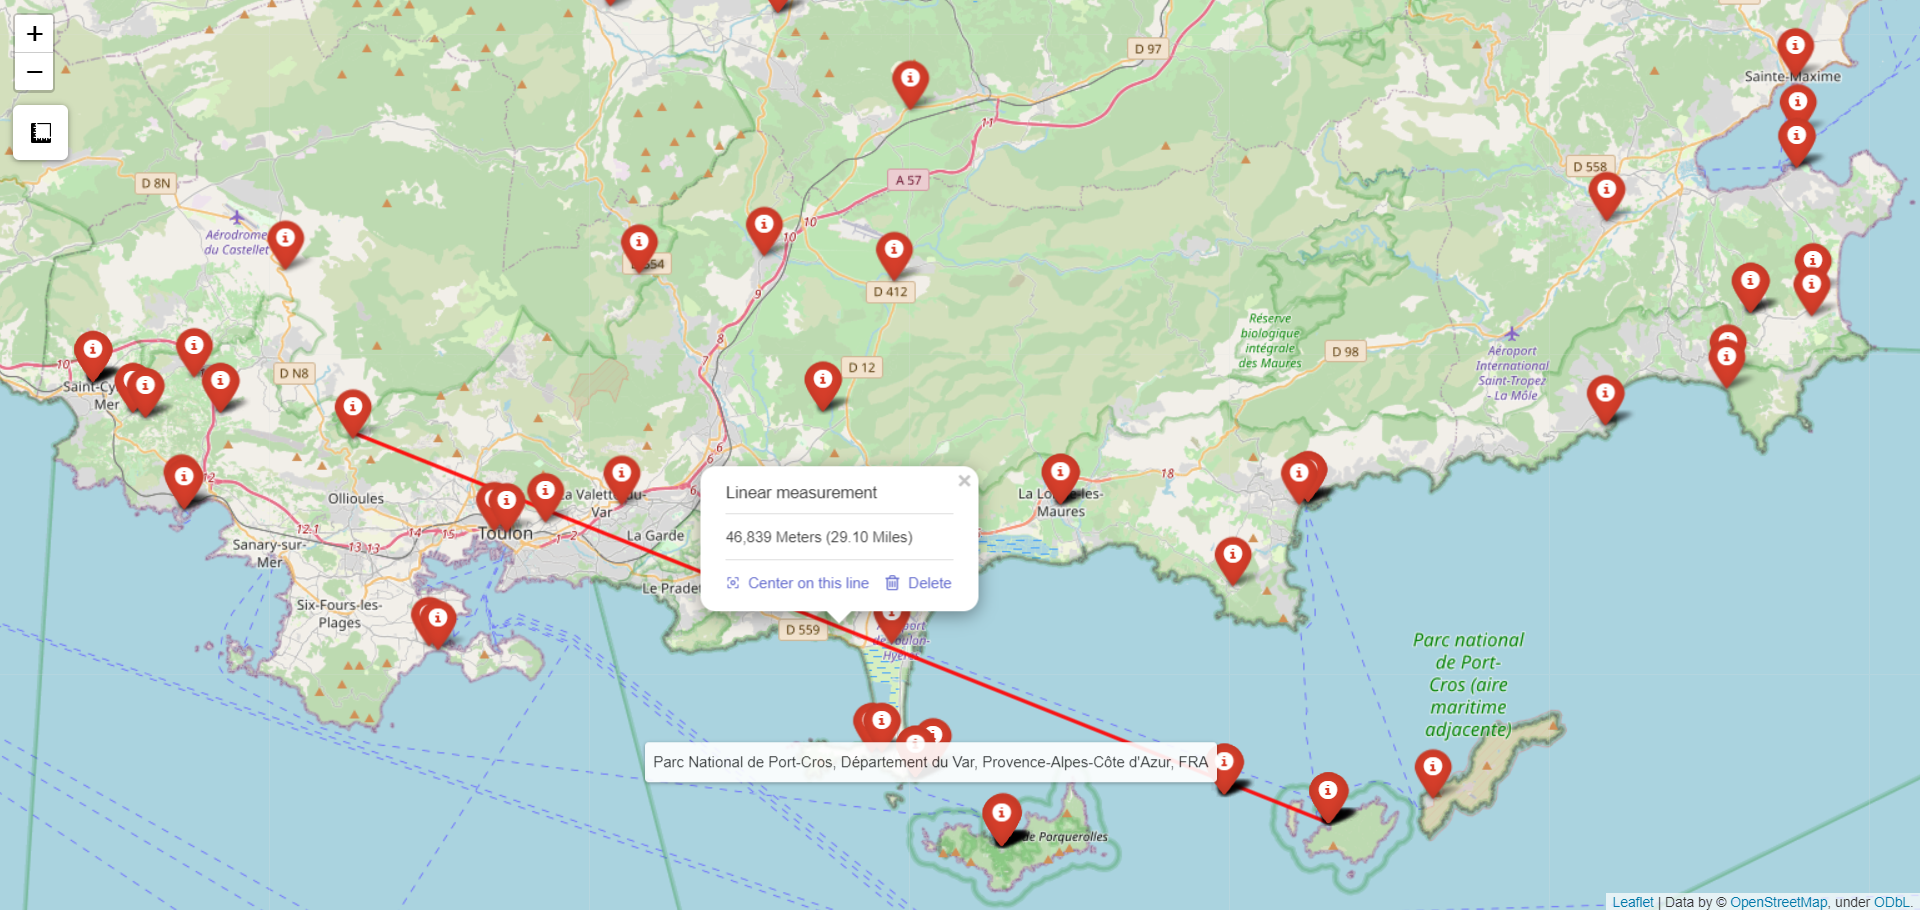

### Choropleth Map
Nous avons mis en place la fonction `showChoroplethFromAdress` qui prend en paramètre deux fichiers à savoir un fichier csv où nous utilisons uniquement les colonnes :
* Latitudes
* Longitudes
* Communes
* Occurences

et un fichier au format json représentant le découpage du département `Var` par **Communes**. Ce découpage peut être réaliser à partir de la plateforme [GeoJson](http://geojson.io/#map=2/20.0/0.0). Ce fichier au format json contient l'ensemble des cordonnées de toutes les communes du **Var**, notre fonction permet de manipuler les deux fichiers... Ci-dessous une illustration de notre découpage :

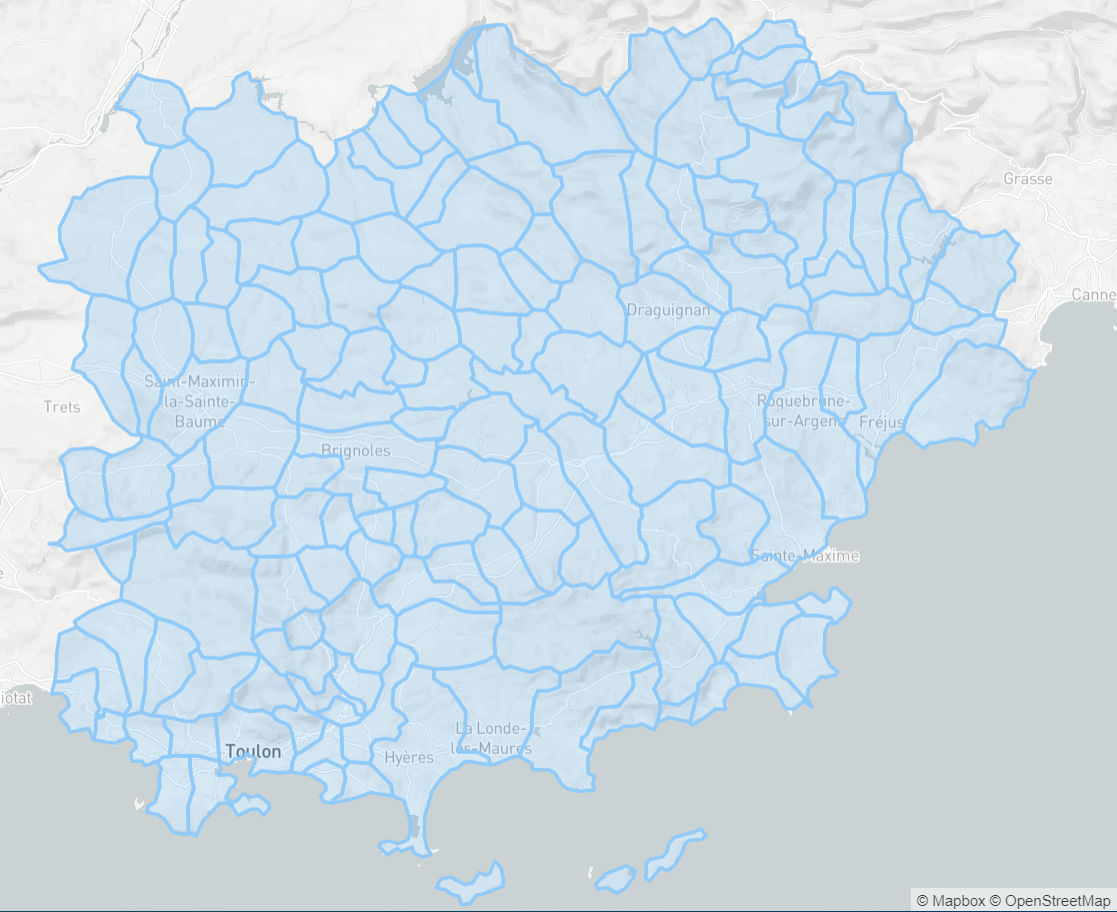

Cette fonction retournera le fichier `choroplethMapZoneDNS.html` qui sera dans le dossier `outputs` placé à la racine de votre projet. Le fichier que vous obtiendrez en sortie sera une carte de `OpenStreetMap`.

In [ ]:
import folium, json
from folium import plugins
import ipywidgets
import pandas as pd

def showChoroplethFromAdress(f_csv, f_geojson):
    # Chargement du fichier json
    with open(f_geojson) as var:
        communes = json.load(var)
    for i in communes['features']:
        i['id'] = i['properties']['nom']
    # Chargement du fichier csv
    zoneDNS = pd.read_csv(f_csv, encoding='utf-16', sep='\t')
    # Carte
    bins = list(zoneDNS['Occurrences'].quantile([0, 0.25, 0.5, 0.75, 1]))
    mapChoropleth = folium.Map([43.9351691, 6.0679194],
                               zoom_start=6)  # La localisation de départ pour cadrer les résultats
    # Choropleth
    folium.Choropleth(geo_data=communes, name='choropleth', data=zoneDNS, columns=['Communes', 'Occurrences'],
                      key_on='feature.id', fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
                      legend_name='Occurrences', highlight=True, bins=bins, reset=True).add_to(mapChoropleth)
    # Calque de controle (activer ou désactiver Choropleth sur la carte
    folium.LayerControl().add_to(mapChoropleth)
    return mapChoropleth.save(outfile='outputs/choroplethMapZoneDNS.html')

Vous devriez obtenir une illustration comme sur l'image ci-dessous :
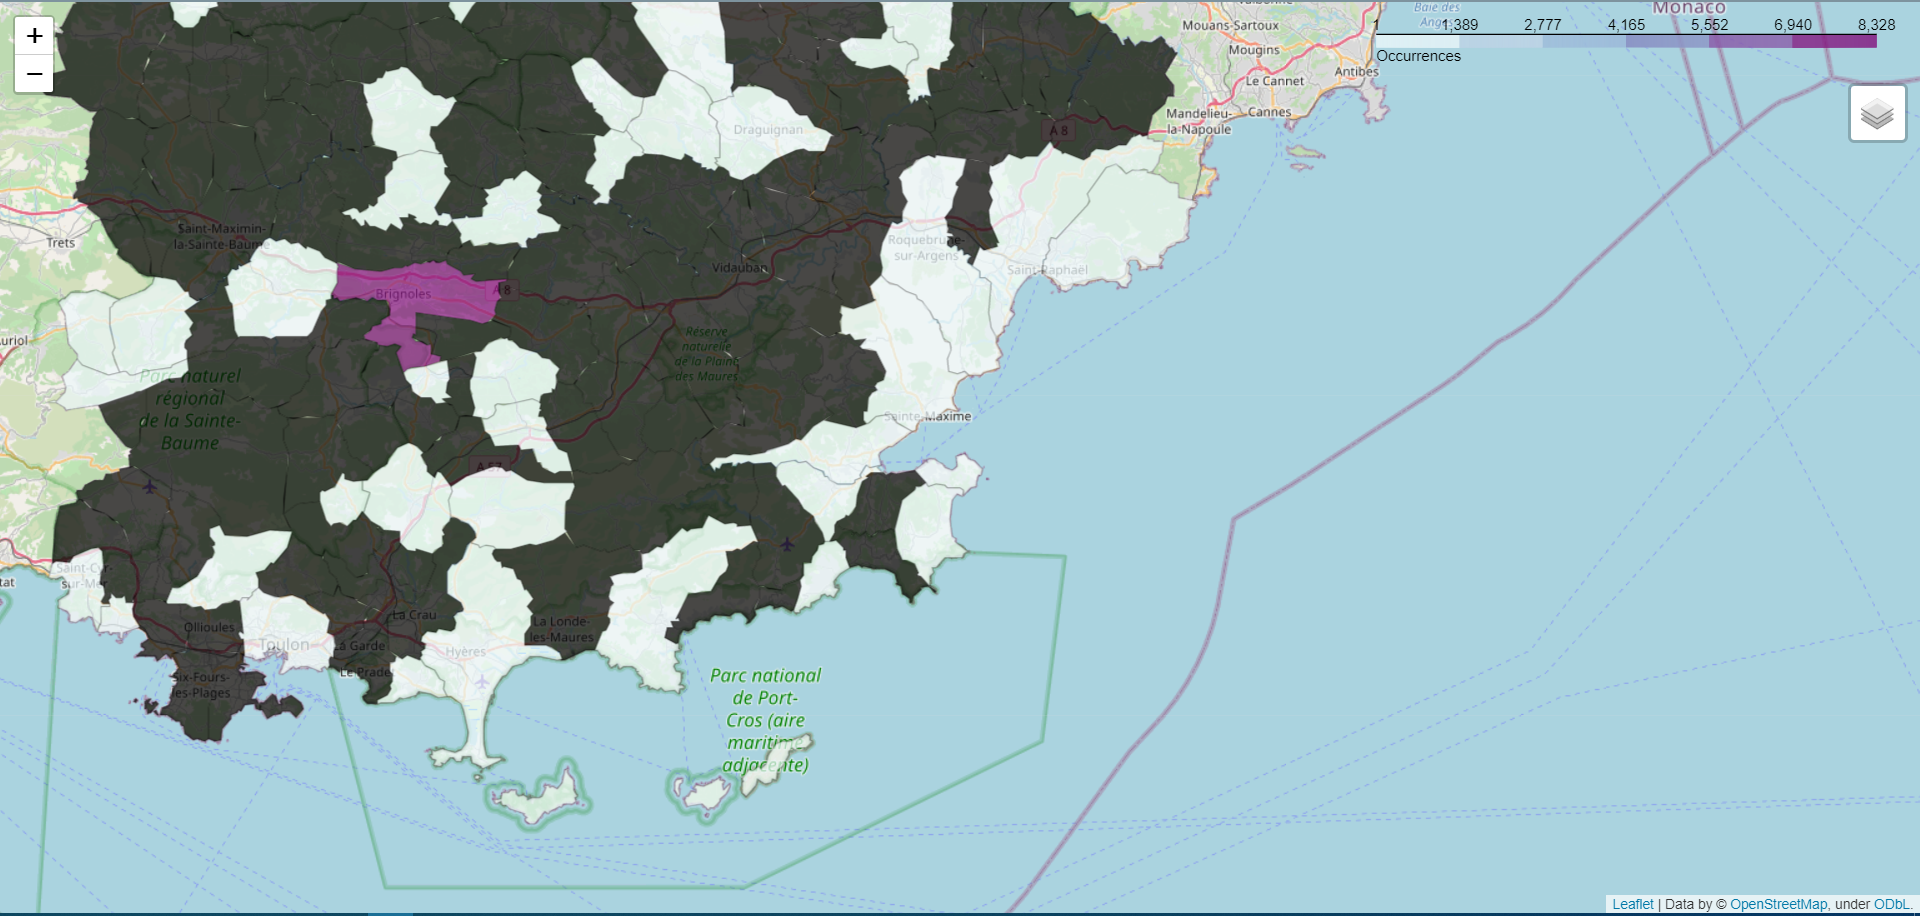